# One-way ANOVA

Imagine you have three groups, and you want to do a one-level ANOVA to test
for overall differences across the groups.

The general technique for a permutation test is:

* You decide on your metric
* You get your metric for the actual data - observed metric
* You permute your data and take the same metric from the permuted data, and
  repeat many times - fake metrics
* You compare your observed metric to your fake metrics, to see how unusual it
  is.

For a two-sample permutation test, your metric is the difference in the two
sample means.

For a three sample version of the test — we need a metric that will be big
where there are big differences between the three groups, and small when there
are small differences.

One good metric could be to:

* Get the sample means for each of the three groups A, B, C, to give `mean_a`,
  `mean_b`, `mean_c`
* Get the mean across all the observations regardless of group
  (`mean_overall`)
* Subtract `mean_overall` from each of `mean_a`, `mean_b`, `mean_c` to give
  `mean_a_diff`, `mean_b_diff`, `mean_c_diff`.

As usual, we need one number as our metric, and as usual, we're interested in
positive as well as negative differences, so we want to get rid of the signs
on these somehow, before adding them up.  One way is to square them, and so
the metric is:

    our_metric = mean_a_diff ** 2 + mean_b_diff ** 2 + mean_c_diff ** 2

This will be big when the individual groups have different means from each
other and small when the means for the groups are pretty similar to each
other, and therefore, to the overall mean.

To follow the recipe above we calculate this metric for the actual groups A,
B, C.   Permute the group labels to give random groups A, B, C, and
recalculate the metric.   See whether the metric in the real data is unusual
in the distribution of the same metric for the permuted groups.

This is the permutation equivalent of the one-way ANOVA.   The one-way ANOVA
just uses some assumptions from the normal distribution to estimate the random
distribution, instead of using permutation to calculate the random
distribution.


## An example

Dataset from <https://dasl.datadescription.com/datafile/contrast-baths>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data corresponds to [this
paper](https://pubmed.ncbi.nlm.nih.gov/19375278/).

From the abstract:

> Methods: Study participants were randomly assigned to one of three treatment
> group protocols--contrast baths with exercise, contrast baths without
> exercise, and an exercise-only control treatment group. Study participants
> were evaluated with hand volumetry, before and after treatment at two
> different data collection periods-pre- and postoperatively.

It is not clear what data we have, but they may be change scores before and
after treatment, for the pre-operative group.

Notice we have three treatment groups, the "Bath" group, the "Bath+Exercise" group and the "Exercise" group.

In [2]:
# Read the raw dataset
baths = pd.read_csv('contrast-baths.txt', sep='\t')
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10
1,Exercise,0
2,Bath,10
3,Bath,5
4,Bath,


Both columns are "objects", meaning strings.

In [3]:
baths.dtypes

Treatment       object
Hand Vol Chg    object
dtype: object

In fact, missing data here is a single space character.  Fix that, by replacing single spaces with empty strings, then converting all the "Hand Vol Chg" values to numbers.

In [4]:
baths['Hand Vol Chg'] = baths['Hand Vol Chg'].replace(' ', '')
baths['Hand Vol Chg'] = pd.to_numeric(baths['Hand Vol Chg'])
baths.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
4,Bath,NaN


For simplicity, drop the missing `NaN` values:

In [5]:
clean_baths = baths.dropna()
clean_baths.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Exercise,0.0
2,Bath,10.0
3,Bath,5.0
5,Exercise,4.0


We are now ready to do the analysis.

Here are the data, plotted by group.

<AxesSubplot:xlabel='Treatment', ylabel='Hand Vol Chg'>

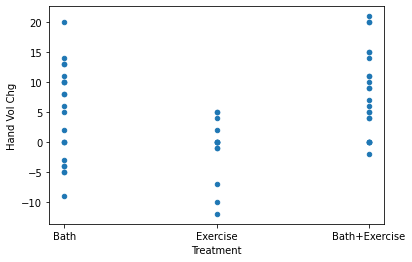

In [6]:
clean_baths.plot.scatter('Treatment', 'Hand Vol Chg')

These are the means for each of the three groups.

In [7]:
group_means = clean_baths.groupby('Treatment').mean()
group_means

,Hand Vol Chg
Treatment,
Bath,4.545455
Bath+Exercise,8.000000
Exercise,-1.071429


This is the overall mean, ignoring the groups:

In [8]:
overall_mean = np.mean(clean_baths['Hand Vol Chg'])
overall_mean

4.559322033898305

Here we plot the data, the group means, and the overall mean on the same plot.

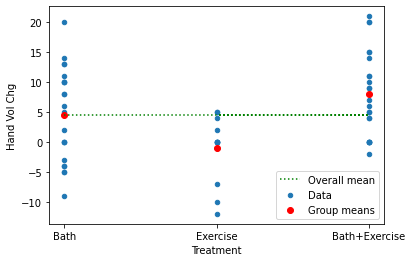

In [9]:
clean_baths.plot.scatter('Treatment', 'Hand Vol Chg',
                         label='Data')
plt.scatter(group_means.index, np.array(group_means), color='red',
            label='Group means')
# A dashed line at the overall mean.
plt.plot(group_means.index,
         [overall_mean, overall_mean, overall_mean],
         ':', color='green',
         label='Overall mean')
plt.legend();

We calculate the difference between the group means and the overall mean.

In [10]:
mean_diffs = group_means - overall_mean
mean_diffs

,Hand Vol Chg
Treatment,
Bath,-0.013867
Bath+Exercise,3.440678
Exercise,-5.630751


We calculate the sum of squares measure of the difference of the group means from the overall mean.

In [11]:
mean_diff_ssq = np.sum(mean_diffs ** 2)
mean_diff_ssq

Hand Vol Chg    43.54381
dtype: float64

This is our metric.  To make this a bit clearer, we put the calculation of our metric into its own function so we can re-use it on different data frames.

In [12]:
def ssq_mean_diffs(df, group_col, val_col):
    overall_mean = np.mean(df[val_col])
    group_means = df.groupby(group_col)[val_col].mean()
    return np.sum((group_means - overall_mean) ** 2)

Check that we get the same answer from the function as we did with the step-by-step calculation:

In [13]:
ssq_mean_diffs(clean_baths, 'Treatment', 'Hand Vol Chg')

43.54380955304242

Next we consider a single trial in our ideal, null, fake world.  We do this by making a copy of the data frame, and then permuting the Treatment labels, so the association between the Treatment and the change values is random.

In [14]:
fake_data = clean_baths.copy()
# Permute the treatment labels
fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
fake_data.head()

,Treatment,Hand Vol Chg
0,Bath,10.0
1,Bath,0.0
2,Bath+Exercise,10.0
3,Bath+Exercise,5.0
5,Exercise,4.0


Next we calculate our metric step by step.

In [15]:
fake_means = fake_data.groupby('Treatment').mean()
# Notice that the overall_mean cannot change because we did not
# change these values.
fake_ssq = np.sum((fake_means - overall_mean) ** 2)
fake_ssq

Hand Vol Chg    12.61677
dtype: float64

We can also use our function to do that calculation, to get the same answer:

In [16]:
ssq_mean_diffs(fake_data, 'Treatment', 'Hand Vol Chg')

12.616769806291572

Now we are ready to do our simulation.  We do 10000 trials, making a new random association, and recalculating our sum of squares metric.

In [17]:
n_iters = 10000
fake_ssqs = np.zeros(n_iters)
for i in np.arange(n_iters):
    fake_data['Treatment'] = np.random.permutation(fake_data['Treatment'])
    fake_ssqs[i] = ssq_mean_diffs(fake_data, 'Treatment', 'Hand Vol Chg')

Of course, because these are sums of squares, they must all be positive.

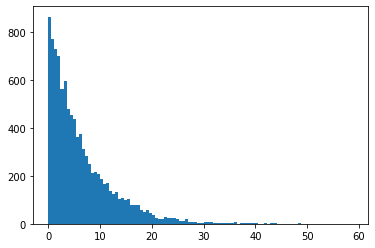

In [18]:
plt.hist(fake_ssqs, bins=100);

How does our observed sum of squares metric compare to the distribution of fake sum of square metrics?

In [19]:
p = np.count_nonzero(fake_ssqs >= float(mean_diff_ssq)) / n_iters
p

0.0011

The p value tells us that this observed metric is very unlikely to have come about in a random world.

## Comparing to standard one-way ANOVA F tests

Notice that we get a similar p value from the standard one-way ANOVA
F-test.  Here is the Statsmodels implementation:

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# The Q() in the formula is just to allow spaces in the variable name.
mod = smf.ols('Q("Hand Vol Chg") ~ Treatment', data=clean_baths).fit()

sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
Treatment,2.0,716.159256,358.079628,7.4148,0.001391
Residual,56.0,2704.383117,48.292556,NaN,NaN


Here is doing the same calculation in Scipy:

In [21]:
from scipy.stats import f_oneway

In [22]:
# Get the values from the individual groups.
treatment = clean_baths['Treatment']
change = clean_baths['Hand Vol Chg']
bath = change[treatment == 'Bath']
both = change[treatment == 'Bath+Exercise']
exercise = change[treatment == 'Exercise']

Do the F-test in Scipy:

In [23]:
f_oneway(bath, both, exercise)

F_onewayResult(statistic=7.414799716344096, pvalue=0.0013907554044090167)